In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.california_housing import read_data
from src.california_housing import impute_data
from src.california_housing import outlier_removal

# Load Data

In [2]:
# Load the train-data
df_train = read_data.read_file(folder="california_housing",filename="strat_train_set", csv=True)

# Visualise Data

When visualising the data with histograms we want to detect variable which display a strange behaviour. Considerung the housing-median-age or the median-house-value one can see that there is a peak at values above 50 for housing-median-age as well as for value above or equal 500'000 for median-house-value. One can assume that these are outliers and have to be removed.

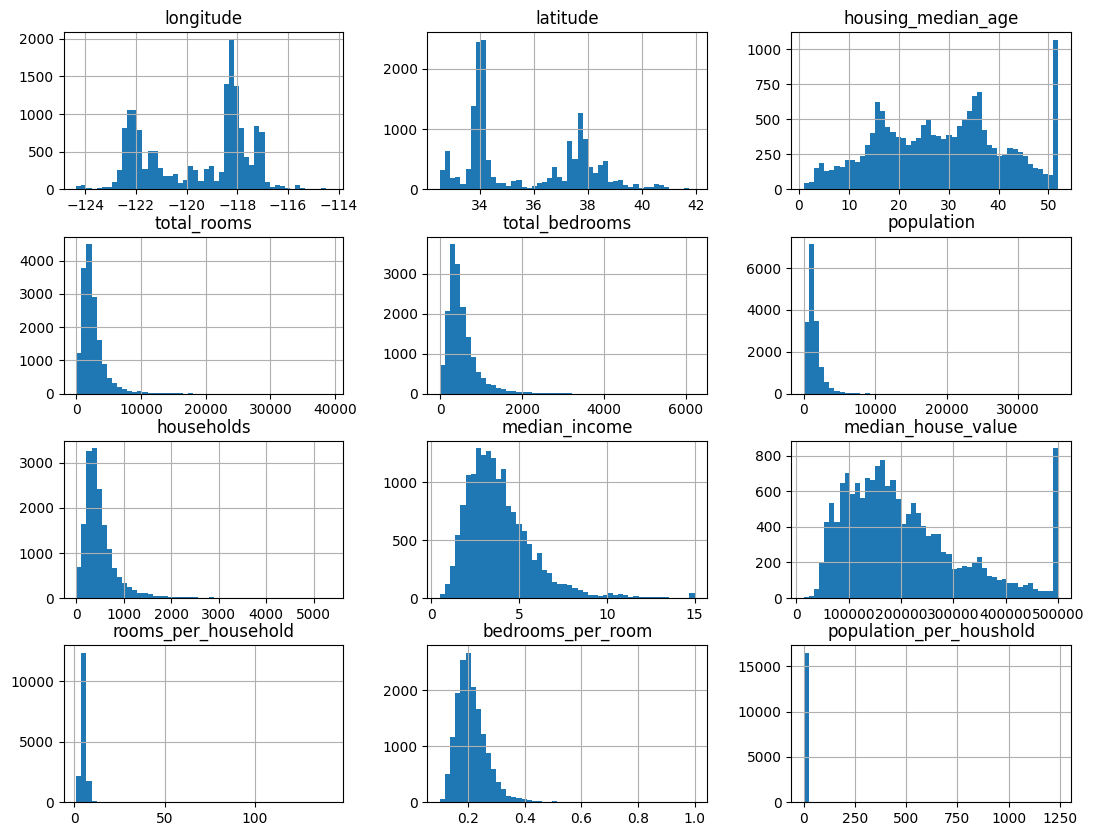

In [3]:
# Plot the distribution of the numerical variables
df_train.hist(bins=50, figsize=(13,10))
plt.show()

When plotting median-house-value againt median-income on a scatterplit it is visible that there are some outliers at play.

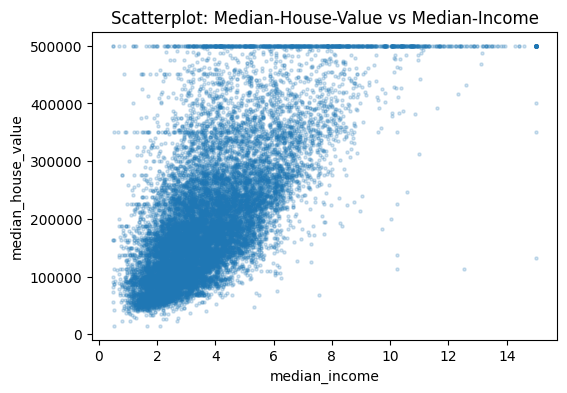

In [4]:
# Plot the relationship of median-income and median-house-value
df_train.plot(kind="scatter", x="median_income", y="median_house_value",
              figsize=(6,4), s=5, alpha=0.2)
plt.title("Scatterplot: Median-House-Value vs Median-Income")
plt.show()

# Outlier Removal

## Imputation

For the outlier removal to work we first have to handle the missing values. In our dataframe missing values occur for the columns total_bedrooms and bedrooms_per_room. Whereas bedrooms_per_room is basically a calculation where total_bedrooms is needed. Therefore we only have to impute the values for column total_bedrooms and afterwards calculate the bedrooms_per_room column. The total_rooms is correlating with the total_bedrooms. One way would be to impute the total bedrooms based on the amount of total rooms.

In [5]:
print(df_train['total_rooms'].corr(df_train['total_bedrooms']))

0.9293908376102377


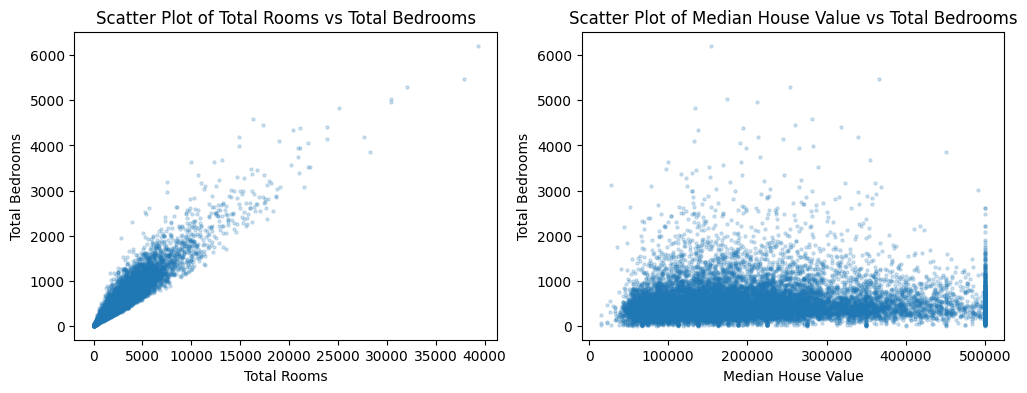

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(x=df_train["total_rooms"], y=df_train["total_bedrooms"], s=5, alpha=0.2)
ax[0].set_xlabel("Total Rooms")
ax[0].set_ylabel("Total Bedrooms")
ax[0].set_title("Scatter Plot of Total Rooms vs Total Bedrooms")

ax[1].scatter(x=df_train["median_house_value"], y=df_train["total_bedrooms"], s=5, alpha=0.2)
ax[1].set_xlabel("Median House Value")
ax[1].set_ylabel("Total Bedrooms")
ax[1].set_title("Scatter Plot of Median House Value vs Total Bedrooms")

plt.show()

Now we will perform the impuation using an iterative Imputer. This method takes all the rows where total bedrooms are not missing a regression will be trained on total rooms, which takes on the role of a predictor whereas total bedrooms is the target. It then estimates the amount of total bedrooms based on the value of total rooms. This means we are building a simple linear regression model to impute the missing values for total bedrooms.

In [7]:
# Impute the missing values
df_after_imputation = impute_data.impute_data(df_train)

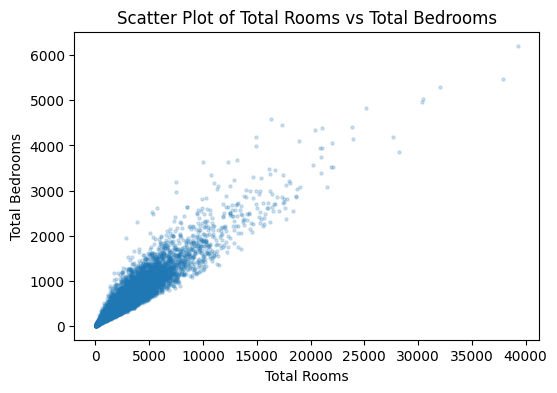

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(x=df_after_imputation["total_rooms"], y=df_after_imputation["total_bedrooms"], s=5, alpha=0.2)
ax.set_xlabel("Total Rooms")
ax.set_ylabel("Total Bedrooms")
ax.set_title("Scatter Plot of Total Rooms vs Total Bedrooms")

plt.show()

## Outlier Removal after imputation

In a first step we have to select the columns of our dataframes where we assume outliers or anomalies to be present. As defined above the columns median_house_value and housing_median_age seem to be infected by outliers.

#### 1. Check Boxplot

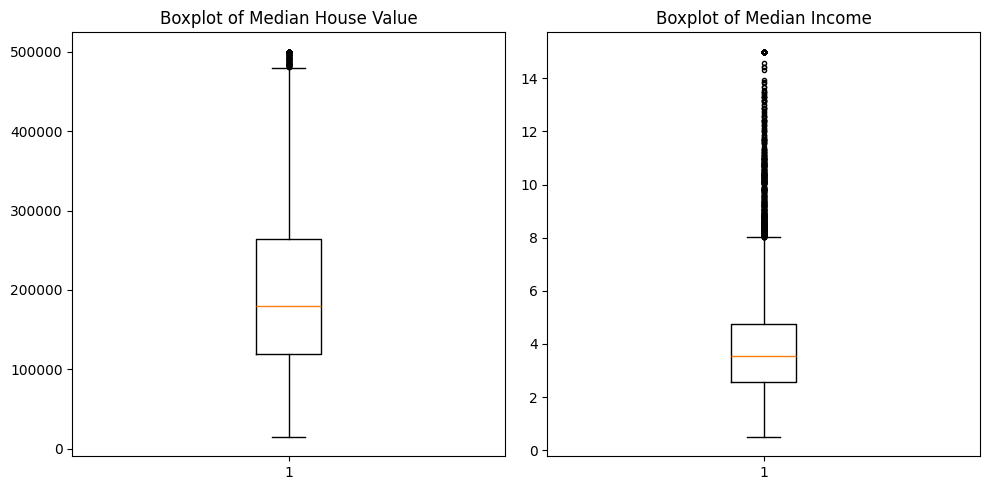

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot for "median_house_value"
bp1 = ax[0].boxplot(df_after_imputation["median_house_value"], sym='.')
ax[0].set_title("Boxplot of Median House Value")
# Boxplot for "median_income"
bp2 = ax[1].boxplot(df_after_imputation["median_income"], sym='.')
ax[1].set_title("Boxplot of Median Income")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Remove Values above upper whisker

In [10]:
# Call the function
df_after_outlier_removal = outlier_removal.remove_upper_outliers(df_after_imputation, "median_house_value")

#### Check result visually

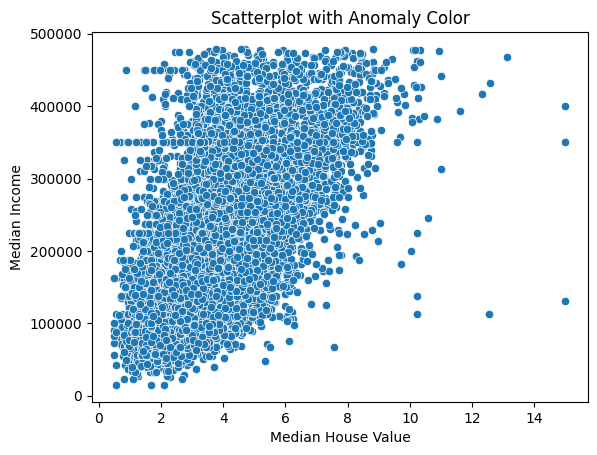

In [11]:
# Create a scatterplot with hue based on the "anomaly" column
sns.scatterplot(x='median_income', y='median_house_value', data=df_after_outlier_removal)

# Add labels and title
plt.xlabel("Median House Value")
plt.ylabel("Median Income")
plt.title("Scatterplot with Anomaly Color")

# Show the plot
plt.show()

#### Calculate possible contamination

In [12]:
# Get contamination
percentage_outliers = outlier_removal.get_percentage_outliers(df_after_outlier_removal, "median_house_value")
print("Percentage of possible Outliers:", percentage_outliers)

Percentage of possible Outliers: 0.01


#### Compute Isolation Forest & Visualise Results

In [13]:
# Compute Isolation Forest to remove outliers
df_after_complete_outlier_removal = outlier_removal.isolation_forest(data=df_after_outlier_removal,
                                                                    anomaly_columns=["median_house_value", "median_income"],
                                                                    percentage_outliers=percentage_outliers,
                                                                    save_model=False)

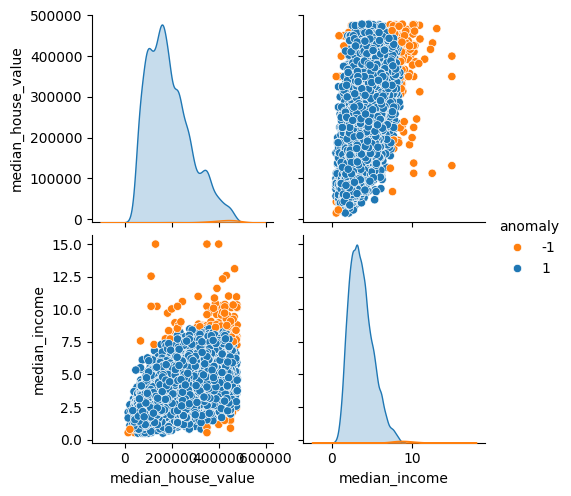

In [14]:
# Visualise Results
color_palette = ["#ff7f0e", "#1f77b4"]
anomaly_columns=["median_house_value", "median_income"]
sns.pairplot(df_after_complete_outlier_removal, vars=anomaly_columns, hue="anomaly", palette=color_palette)
plt.show()

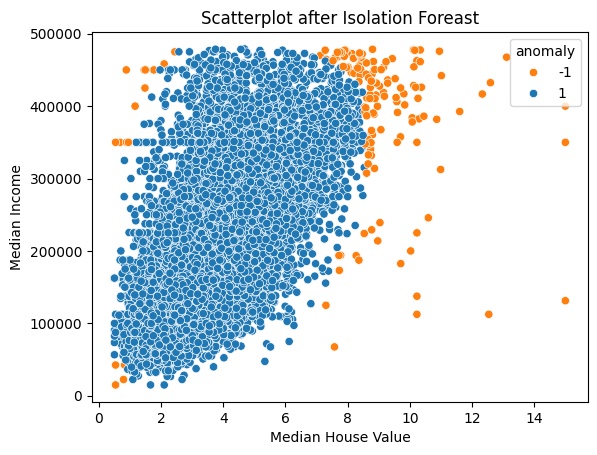

In [15]:
# Create a scatterplot with hue based on the "anomaly" column
sns.scatterplot(x='median_income', y='median_house_value',
                hue='anomaly', palette=color_palette,
                data=df_after_complete_outlier_removal)

# Add labels and title
plt.xlabel("Median House Value")
plt.ylabel("Median Income")
plt.title("Scatterplot after Isolation Foreast")

# Show the plot
plt.show()